# Wine aroma prediction using CNNs
Here will be used CNN to predict wine aroma from the previously obtained wine composition matrices

In [1]:
#Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.cuda.amp import autocast
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import ( 
                        average_precision_score, 
                        precision_recall_fscore_support, 
                        multilabel_confusion_matrix
)
import torchvision as tv
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast
import seaborn as sns
import pandas as pd 

## 1. Working with data
At this stage, loads the previously prepared data, and process the data for further neural networking 

In [2]:
# Loading data
X_array =  np.load('X_array.npy')
Y_array =  np.load('Y_array.npy')

In [3]:
# Separation of data into training, validation and test data in the ratio of 70:20:10
X_train, X_test, y_train, y_test = train_test_split(X_array, Y_array, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
# Conversion to a tensor
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_val = torch.tensor(X_val)
y_val = torch.tensor(y_val)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

In [5]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

323
323
81
81
45
45


In [6]:
use_amp = True

In [7]:
# Create a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [8]:
dataset_train = CustomDataset(X_train, y_train)
dataset_val = CustomDataset(X_val, y_val)
dataset_test = CustomDataset(X_test, y_test)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle=False)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

## 2. CNN architecture
At this step it designs the architecture of the neural network, in this file the optimal architecture is specified

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Define convolution layers with batch normalization
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        # Pulling
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 11 * 25, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
        # Dropout to prevent overtraining
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
 
        # Straightening before feeding to the full-link layer
        x = x.view(-1, 128 * 11 * 25)  # Flatten
        
        # Fully connected layers with activation and dropout
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)  # Dropout after the first full-link layer
        
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Creating an instance of a neural network
net = ConvNet()
# Print the architecture of the neural network
print(net)

ConvNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=35200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## 3. Neural network training
Set the training parameters and train the neural network

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
epochs = 50
lr = 1e-3
weight_decay = 1e-4
n_splits = 5
seed = 42

In [ ]:
class_names = ['Herbs and spices','Tobacco/Smoke','Wood','Berries','Citrus',
                'Fruits','Nuts','Coffee','Chocolate/Cacao','Flowers']

In [ ]:
def build_cnn():
    return ConvNet().to(device)

def train_model(model, dl_train, epochs=epochs):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCEWithLogitsLoss()
    for _ in range(epochs):
        for x, y in dl_train:
            x = x.to(device).float()
            y = y.to(device).float()
            if x.dim() == 3:  # (B, H, W) -> (B, 1, H, W)
                x = x.unsqueeze(1)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            opt.step()
    return model

In [ ]:
@torch.no_grad()
def per_class_ap(model, dl):
    model.eval()
    Ys, Ps = [], []
    for x, y in dl:
        x = x.to(device).float()
        y = y.to(device).float()
        if x.dim() == 3: x = x.unsqueeze(1)
        logits = model(x)
        Ys.append(y.cpu().numpy())
        Ps.append(torch.sigmoid(logits).cpu().numpy())
    Y = np.concatenate(Ys, axis=0)  # (N, C)
    P = np.concatenate(Ps, axis=0)  # (N, C)

    C = Y.shape[1]
    ap = np.full(C, np.nan, dtype=float)
    support = Y.sum(axis=0)
    for j in range(C):
        ap[j] = average_precision_score(Y[:, j], P[:, j]) if support[j] > 0 else np.nan
    return ap

In [18]:
@torch.no_grad()
def per_sample_accuracy(model, loader, threshold=0.5):
    model.eval()
    device = next(model.parameters()).device
    accs = []
    for x, y in loader:
        x = x.to(device).float()
        if x.dim() == 3:  # (B,H,W) -> (B,1,H,W)
            x = x.unsqueeze(1)
        y = y.to(device).float()

        logits = model(x)                         # (B, C)
        probs  = torch.sigmoid(logits)
        preds  = (probs > threshold).float()
        acc_b  = (preds == y).float().mean(dim=1) # (B,)
        accs.append(acc_b.cpu().numpy())
    return np.concatenate(accs, axis=0)

def bootstrap_mean_std(values, n_boot=2000, seed=42):

    rng = np.random.default_rng(seed)
    values = np.asarray(values, dtype=float)
    n = len(values)
    boot_means = [values[rng.integers(0, n, size=n)].mean() for _ in range(n_boot)]
    return float(values.mean()), float(np.std(boot_means, ddof=1))

In [ ]:
full_train = CustomDataset(X_train, y_train)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
idx_all = np.arange(len(X_train))

ap_per_fold = [] 

In [ ]:
for fold, (tr_idx, va_idx) in enumerate(kf.split(idx_all), 1):
    print(f"\n==== Fold {fold}/{n_splits} ====")
    dl_tr = DataLoader(Subset(full_train, tr_idx), batch_size=batch_size, shuffle=True)
    dl_va = DataLoader(Subset(full_train, va_idx), batch_size=batch_size, shuffle=False)

    model = build_cnn()
    model = train_model(model, dl_tr, epochs=epochs)
    ap_fold = per_class_ap(model, dl_va)
    ap_per_fold.append(ap_fold)
    print("Per-class PR-AUC (val):", np.round(ap_fold, 3))

ap_mat = np.vstack(ap_per_fold)            # shape: (K, C)
cv_mean = np.nanmean(ap_mat, axis=0)       # (C,)
cv_std  = np.nanstd(ap_mat,  axis=0, ddof=1)

final_ds_train = CustomDataset(X_train, y_train)
final_dl_train = DataLoader(final_ds_train, batch_size=batch_size, shuffle=True)
test_ds = CustomDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

final_model = build_cnn()
final_model = train_model(final_model, final_dl_train, epochs=epochs)
test_ap = per_class_ap(final_model, test_dl)  # (C,)

df_pr_auc = pd.DataFrame({
    "Aroma class":        class_names,
    "CV PR-AUC (mean)":   np.round(cv_mean, 3),
    "CV PR-AUC (std)":    np.round(cv_std, 3),
    "Test PR-AUC":        np.round(test_ap, 3)
}).sort_values(by="CV PR-AUC (mean)", ascending=False).reset_index(drop=True)


print("\n=== Per-class PR-AUC (CV & Test) ===")
print(df_pr_auc.to_string(index=False))

# df_pr_auc.to_csv("per_class_prauc_cv_test.csv", index=False)


==== Fold 1/5 ====
Per-class PR-AUC (val): [0.778 0.151 0.2   0.741 0.409 0.754 0.284 0.31  0.333 0.706]

==== Fold 2/5 ====
Per-class PR-AUC (val): [0.799 0.144 0.155 0.753 0.402 0.825 0.119 0.104 0.184 0.478]

==== Fold 3/5 ====
Per-class PR-AUC (val): [0.728 0.134 0.245 0.564 0.38  0.837 0.112 0.053 0.185 0.368]

==== Fold 4/5 ====
Per-class PR-AUC (val): [0.669 0.066 0.149 0.737 0.431 0.744 0.05  0.036 0.119 0.401]

==== Fold 5/5 ====
Per-class PR-AUC (val): [0.707 0.121 0.324 0.688 0.393 0.703 0.057 0.133 0.119 0.544]

=== Per-class PR-AUC (CV & Test) ===
     Aroma class  CV PR-AUC (mean)  CV PR-AUC (std)  Test PR-AUC
          Fruits             0.773            0.057        0.919
Herbs and spices             0.736            0.053        0.706
         Berries             0.696            0.078        0.709
         Flowers             0.499            0.134        0.596
          Citrus             0.403            0.019        0.363
            Wood             0.215        

In [19]:
test_acc_per_sample = per_sample_accuracy(final_model, test_dl, threshold=0.5)
test_acc_mean, test_acc_std = bootstrap_mean_std(test_acc_per_sample, n_boot=2000, seed=42)

print(f"Test Accuracy: {test_acc_mean:.4f} ± {test_acc_std:.4f}")

Test Accuracy: 0.7978 ± 0.0187


## 4. PR-AUC Bars — Test Set

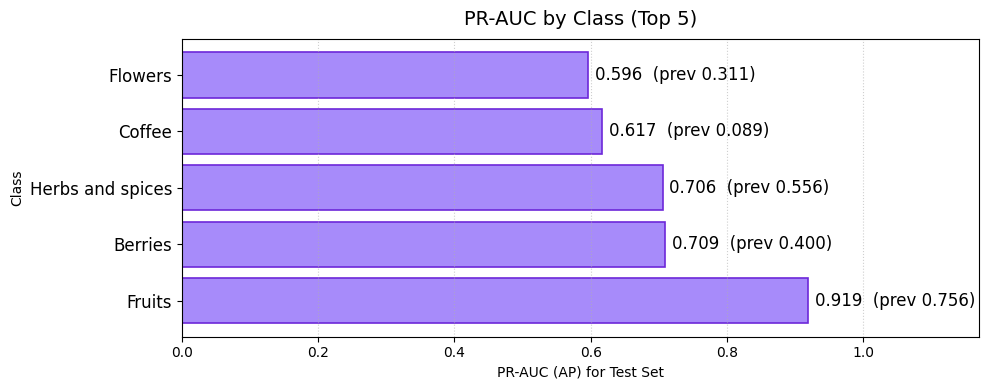

In [16]:
def plot_pr_auc_test(ap_values, class_names, y_test_tensor, savepath=None, show_lift=True, top_k=None):
    import numpy as np
    import matplotlib.pyplot as plt

    ap_values = np.asarray(ap_values, dtype=float)
    if hasattr(y_test_tensor, "cpu"):
        Yt = y_test_tensor.cpu().numpy()
    else:
        Yt = np.asarray(y_test_tensor)

    # Prevalence 
    prev = np.nanmean(Yt, axis=0).astype(float)

    ap_safe = np.copy(ap_values)
    ap_sort_key = np.where(np.isnan(ap_safe), -1.0, ap_safe)
    order = np.argsort(-ap_sort_key)

    ap_sorted   = ap_values[order]
    prev_sorted = prev[order]
    names_sorted = [class_names[i] for i in order]

    if top_k is not None:
        k = int(min(top_k, len(ap_sorted)))
        ap_sorted   = ap_sorted[:k]
        prev_sorted = prev_sorted[:k]
        names_sorted = names_sorted[:k]

    y_pos = np.arange(len(ap_sorted))

    fig, ax = plt.subplots(figsize=(10, max(4, 0.5 * len(ap_sorted))))
    bars = ax.barh(
        y_pos,
        np.nan_to_num(ap_sorted, nan=0.0),
        color="#a78bfa", edgecolor="#6d28d9", lw=1.2
    )
    ax.set_xlim(0, 1.17)
    ax.set_xlabel("PR-AUC (AP) for Test Set", fontsize=10)
    ax.set_ylabel("Class")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names_sorted, fontsize=12)
    ax.grid(axis="x", linestyle=":", alpha=0.6)
    ax.set_title("PR-AUC by Class (Top {})".format(len(ap_sorted)), fontsize=14, pad=10)

    for bar, apv, pv in zip(bars, ap_sorted, prev_sorted):
        y = bar.get_y() + bar.get_height() / 2
        x_text = min((0.0 if np.isnan(apv) else apv) + 0.01, 0.98)
        label = "n/a" if np.isnan(apv) else f"{apv:.3f}"
        if show_lift:
            label = f"{label}  (prev {pv:.3f})"
        ax.text(x_text, y, label, va="center", fontsize=12)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()

plot_pr_auc_test(test_ap, class_names, y_test, top_k=5, show_lift=True)

In [20]:
# torch.save(model.state_dict(), "cnn_weights.pt")
# print("[saved] cnn_weights.pt")

[saved] cnn_weights.pt
